In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date

pd.set_option('display.max_rows', 10)

In [2]:
#set conditions for a single timeseries
location = 'LIB'  #LIB or DWR, see reservoir dataframe below for options

#btwn 1928-2008 for nrni, btwn 1950-2007 for livneh, btwn 1950-2099 for gcms
startyr = 1950  #1950 or 2030 
endyr = startyr + 50
special_years = [1953]  #for hydrograph, could be one or many or comment out below

#set file locations
filepath = '/Users/vano/Dropbox/raid/rmjoc2/%s.csv'

#set path to output figures
filepathfigs = '/Users/vano/Desktop/'

In [3]:
#Information on possible locations and time periods

#options:'nrni','livneh','gcm'
timeseries = 'gcm'

rcps = ['RCP45', 'RCP85']
gcms = ['CCSM4', 'CSIROMk360', 'GFDLESM2M', 'HadGEM2ES', 'MIROC5', 
       'CNRMCM5', 'CanESM2', 'HadGEM2CC', 'IPSLCM5AMR', 'inmcm4']
gcmsnames = ['CCSM4', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M', 'HadGEM2-ES', 'MIROC5', 
       'CNRM-CM5', 'CanESM2', 'HadGEM2-CC', 'IPSL-CM5A-MR', 'inmcm4']
downscales = ['maca', 'bcsd']
hydros = ['PRMS', 'VIC']

#set gcm options (will eventually loop), remember index starts at zero
rcp = rcps[1]
gcm = gcms[9]
gcmname = gcmsnames[9]
downscale = downscales[1]
hydro = hydros[1]

reservoir = [{'LIB': 'Libby', 'DWR': 'Dworshak'} , # name
             {'LIB': 'LIB5N', 'DWR': 'DWR5N'},  # month forecast period starts
             {'LIB': 4, 'DWR': 4},  # month forecast period starts
             {'LIB': 8, 'DWR': 7},  # month forecast period ends
             {'LIB': 'April-August', 'DWR': 'April-July', 'XXX' : 'test'},  # forecast period description
             {'LIB': 22, 'DWR' : 25}, # y-axis height for histogram
             {'LIB': 160000, 'DWR' : 25}, # y-axis height for hydrograph
             {'LIB': 4.8, 'DWR' : 2}, # dry year threshold
             {'LIB': 7.5, 'DWR' : 2}] # wet year threshold
               
reservoir = pd.DataFrame(reservoir, index=['name', 'nrni_name', 'm_start', 'm_end', 
                                           'fcst_desc', 'hist_height', 'hydro_height', 'dry_thresh', 'wet_thresh'])

# bins for histogram
bins = pd.DataFrame([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5], columns=['DWR']) 
bins['LIB'] = pd.DataFrame([0.2, 1.2, 2.1, 3.0, 3.9, 4.8, 5.7, 6.6, 7.5, 8.4, 9.3, 10.2, 11.10, 12.0, 12.9])

#DO TO:
#set up loop to read in GCM options
#read out Oriana's files with same BCSD or bcsd

#question: why limiting bins to the first assigned value (e.g. below)? Did quick work around by assigning DWR bins first.
#bins = pd.DataFrame([2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5], columns=['LIB']) 
#bins['DWR'] = pd.DataFrame([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]) 

In [4]:
#Read in files

if timeseries == 'gcm':
    filename = '%s/%s/%s/%s/%s_%s_BCSD_%s_P1-%s-biascorrected_streamflow-provisional_0.5' % (rcp, gcm, downscale, hydro, gcmname, rcp, hydro, location)
    df2 = pd.read_csv(filepath%(filename), comment='#', index_col=0, parse_dates=True)
    ts = df2['biascorrected_streamflow']
    ts_name = '%s.%s.%s.%s' % (rcp, gcm, downscale, hydro)

if timeseries == 'livneh':
    filename = 'livneh/historical_livneh_VIC_P1-%s-biascorrected_streamflow-provisional_0.3' % (location)
    df2 = pd.read_csv(filepath%(filename), comment='#', index_col=0, parse_dates=True) 
    ts = df2['biascorrected_streamflow']
    ts_name = 'Livneh historical'

if timeseries == 'nrni':
    filename = 'nrni/NRNI_Flows_1929-2008_Corrected_08-2016'
    df = pd.read_csv(filepath%filename, skiprows=range(1, 7), usecols=range(1,199))
    nrni=df[reservoir.loc["nrni_name","%s" % (location)]]
    ts_name = 'NRNI flows'
    
    #note: nrni dataset had funny date assignment, since only have to read in once, manually assigning them
    rng = pd.date_range('07/1/1928', periods=29312, freq='D')
    ts = pd.Series(nrni.values, index=rng)  
    ts = ts.astype(np.float)

tdf = ts.to_frame('streamflow')
filepath%filename

'/Users/vano/Dropbox/raid/rmjoc2/RCP85/inmcm4/bcsd/VIC/inmcm4_RCP85_BCSD_VIC_P1-LIB-biascorrected_streamflow-provisional_0.5.csv'

In [5]:
# helper functions for finding day of water year and water year

def water_day(indate):
    doy = indate.timetuple().tm_yday
    if doy >= 274:
        outdate = doy - 274
    else:
        outdate = doy + 91
    return outdate

def water_year(year, month):
    if month > 9:
        return year + 1
    return year

In [6]:
tdf['wyear'] = [water_year(i.year, i.month) for i in tdf.index]
tdf['dowy'] = [water_day(i) for i in tdf.index]

In [7]:
twy = pd.pivot_table(tdf, index='dowy', columns='wyear')['streamflow']
wy_median = pd.DataFrame(twy[range(startyr, endyr)].median(axis=1), columns=['median'])

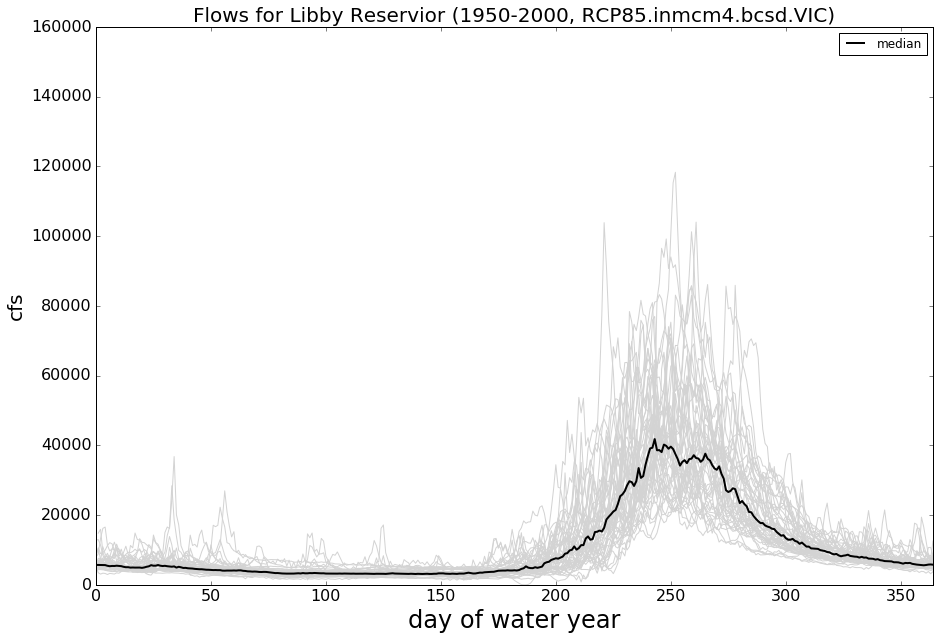

In [8]:
#hydrograph figure

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

twy[range(startyr, endyr)].plot(c='lightgray', legend=False, ax=ax)
#twy[special_years].plot(legend=True, ax=ax)
wy_median.plot(c='black', legend=True, linewidth=2, ax=ax, fontsize=16)

name = reservoir.loc["name","%s" % (location)]
plt.xlabel("day of water year", fontsize=24)
plt.ylabel("cfs", fontsize=20)
plt.title('Flows for %s Reservior (%i-%i, %s)' % (name, startyr, endyr, ts_name), fontsize=20)
plt.rc('legend', fontsize=12) 
ax.set_ylim([0, reservoir.loc["hydro_height","%s" % (location)]])

plt.savefig('%s/%s_%s_hydrograph_%i-%i.pdf' % (filepathfigs, name, ts_name, startyr, endyr))

# question: how change legend? plt.legend(fontsize=20) makes all years show up, the plt.rc doesn't change wyear
# eventually: make y axis dates
# eventually: do if statement to remove special years if not highlighted above

In [9]:
#Calcuations for flow duration curve

x = tdf[ '%i-10-01' % (startyr) : '%i-09-30' % (endyr)].sort_values(by="streamflow", ascending=False)
dailysort=x['streamflow']

count = len(dailysort.values)

fdc = pd.DataFrame(dailysort.values, columns=['sorted']) 
fdc['count'] = pd.DataFrame(range(1,count+1))  
fdc['x'] = pd.DataFrame(100*fdc['count']/(count+1))

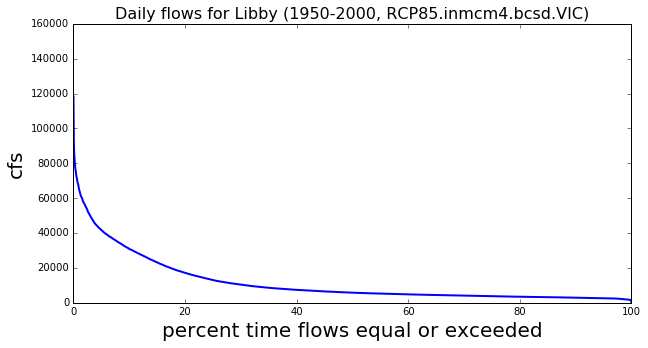

In [10]:
#flow duration curve figure

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(fdc['x'],fdc['sorted'], linewidth=2)

name = reservoir.loc["name","%s" % (location)]
plt.xlabel("percent time flows equal or exceeded", fontsize=20)
plt.ylabel("cfs", fontsize=20)
plt.title('Daily flows for %s (%i-%i, %s)' % (name, startyr, endyr, ts_name), fontsize=16)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=14)
ax.set_ylim([0, reservoir.loc["hydro_height","%s" % (location)]])

plt.savefig('%s/%s_%s_flow_duration_curve_%i-%i.pdf' % (filepathfigs, name, ts_name, startyr, endyr))

#question: odd. doesn't change plt.rc unless return in the box, a better way to do it?

In [11]:
#calculate water supply forecast period in MAF

tdfstrm = tdf['streamflow']
tmm = tdfstrm[ '%i-10-01' % (startyr) : '%i-09-30' % (endyr)].resample('1MS', how='sum')
wsf = tmm[(tmm.index.month >= reservoir.loc["m_start","%s" % (location)]) & (tmm.index.month <= reservoir.loc["m_end","%s" % (location)])].resample('AS', how='sum')
wsf_MAF = wsf*3600*24/43560/1000000

In [12]:
# calculate below dry threshold
orig = reservoir.loc["dry_thresh","%s" % (location)]
dry_count = (wsf_MAF < orig).sum()
orig = reservoir.loc["wet_thresh","%s" % (location)]
wet_count = (wsf_MAF > orig).sum()
all_count = len(wsf_MAF)

percentdry = 100*dry_count/all_count
percentwet = 100*wet_count/all_count

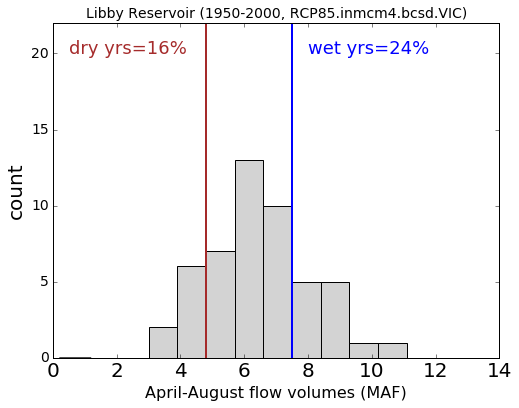

In [13]:
#histogram

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.hist(wsf_MAF, bins=bins['%s' % (location)], color='lightgray')
plt.plot([reservoir.loc["dry_thresh","%s" % (location)], reservoir.loc["dry_thresh","%s" % (location)]],
         [0, reservoir.loc["hist_height","%s" % (location)]], color='brown', linewidth=2) 
plt.plot([reservoir.loc["wet_thresh","%s" % (location)], reservoir.loc["wet_thresh","%s" % (location)]],
         [0, reservoir.loc["hist_height","%s" % (location)]], color='blue', linewidth=2)

name = reservoir.loc["name","%s" % (location)]
desc = reservoir.loc["fcst_desc","%s" % (location)]
plt.xlabel("%s flow volumes (MAF)" % (desc), fontsize=16)
plt.ylabel("count", fontsize=20)
plt.title('%s Reservoir (%i-%i, %s)' % (name, startyr, endyr, ts_name), fontsize=14)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=14)
plt.text(.5,20,'dry yrs=%i%%' % (percentdry),fontsize=18, color='brown')
plt.text(8,20,'wet yrs=%i%%' % (percentwet),fontsize=18, color='blue')
ax.set_ylim([0, reservoir.loc["hist_height","%s" % (location)]])

plt.savefig('%s/%s_%s_water_supply_forecast_histogram_%i-%i.pdf' % (filepathfigs, name, ts_name, startyr, endyr))

#eventually: figure out how to set yaxis to be a few bigger than largest bin, now set height in reservior df

In [14]:
#Seasonal and annual timing

#TO DO
#calculate date of 1/2 seasonal and annual flow volumes